# Binary Sentiment Analysis Using Naive Bayes Algorithm built from scratch :


---


### Overview :

* Train a naive bayes model on a sentiment analysis task
* Test the model on tweets dataset
* Compute ratios of positive words to negative words
* Do some error analysis
* Predict on your own tweet !



<a name='0'></a>
## Importing Functions and Data

In [139]:
import re
import pdb
import itertools
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer




In [140]:

nltk.download('stopwords')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [141]:
tweets_data= pd.read_csv("data/sentiment_analysis.csv")
tweets_data

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...
...,...,...,...
7915,7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7916,7917,0,We would like to wish you an amazing day! Make...
7917,7918,0,Helping my lovely 90 year old neighbor with he...
7918,7919,0,Finally got my #smart #pocket #wifi stay conne...


In [142]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


## Useful plots for EDA

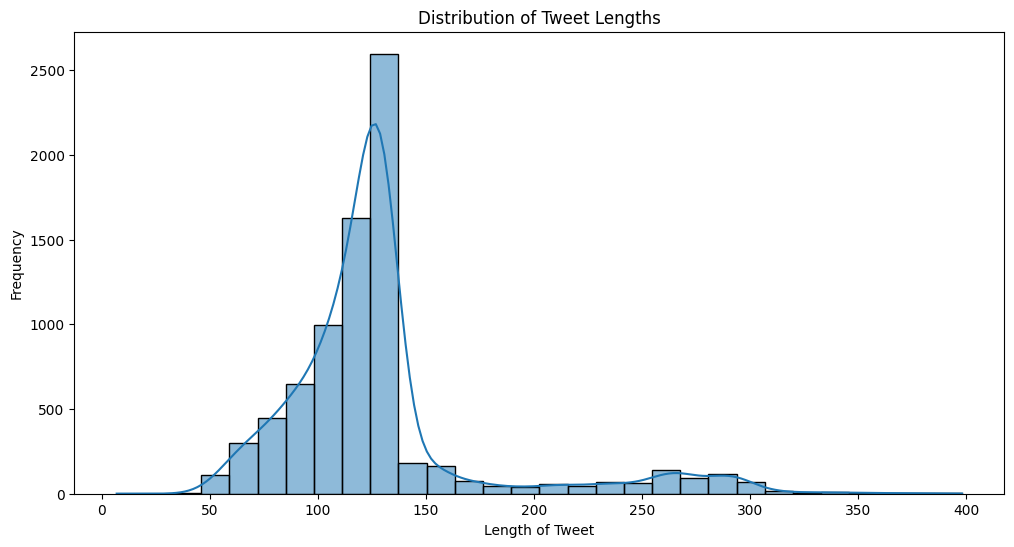

In [143]:


# Plot the distribution of tweet lengths
tweet_lengths = tweets_data['tweet'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(tweet_lengths, bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()







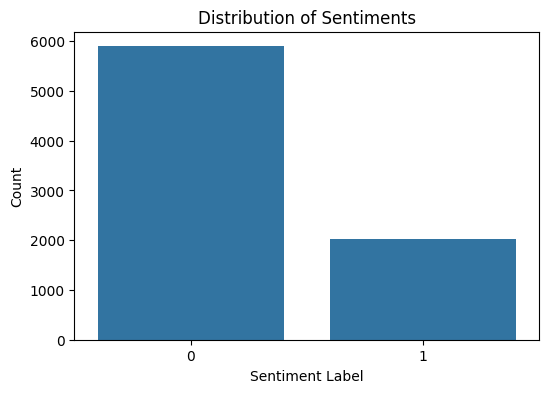

In [144]:
# Plot the distribution of labels (sentiments)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=tweets_data)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

### Downsampling the data for balanced classes

In [145]:

def balance_dataframe(df, label_column):
    """
    Balance the DataFrame by undersampling the majority class.

    Parameters:
    df (pd.DataFrame): The DataFrame to balance.
    label_column (str): The name of the column containing the class labels.

    Returns:
    pd.DataFrame: A balanced DataFrame.
    """
    # Calculate the counts of each class
    class_counts = df[label_column].value_counts()

    # Find the count of the minority class
    min_class_count = class_counts.min()

    # Create a list to store the DataFrame slices
    df_slices = []

    for class_label in class_counts.index:
        df_class = df[df[label_column] == class_label]
        df_class_sampled = df_class.sample(min_class_count, random_state=42)
        df_slices.append(df_class_sampled)

    # Concatenate the downsampled DataFrames
    balanced_df = pd.concat(df_slices)

    # Shuffle the DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

tweets_data=balance_dataframe(tweets_data,'label')
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4052 entries, 0 to 4051
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4052 non-null   int64 
 1   label   4052 non-null   int64 
 2   tweet   4052 non-null   object
dtypes: int64(2), object(1)
memory usage: 95.1+ KB


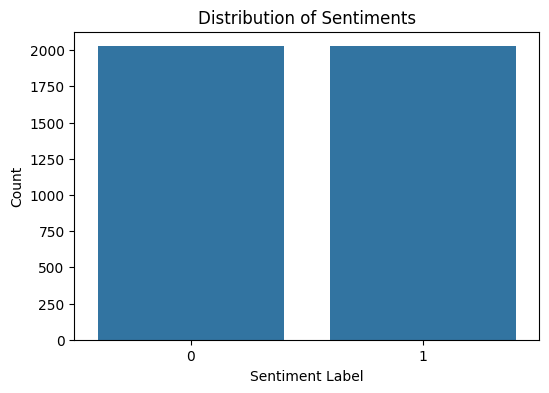

In [146]:
# Plot the distribution of the balanced  labels (sentiments)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=tweets_data)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

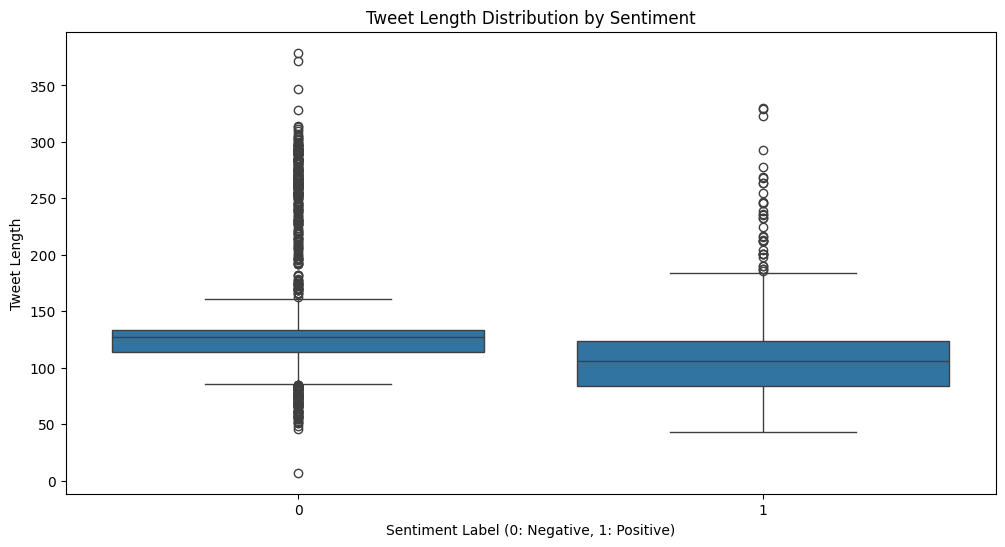

In [147]:
#Sentiment distribution by tweet length
df2=pd.DataFrame()
df2['tweet_length'] = tweets_data['tweet'].str.len()
df2['label']=tweets_data['label']
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='tweet_length', data=df2)
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Sentiment Label (0: Negative, 1: Positive)')
plt.ylabel('Tweet Length')
plt.show()

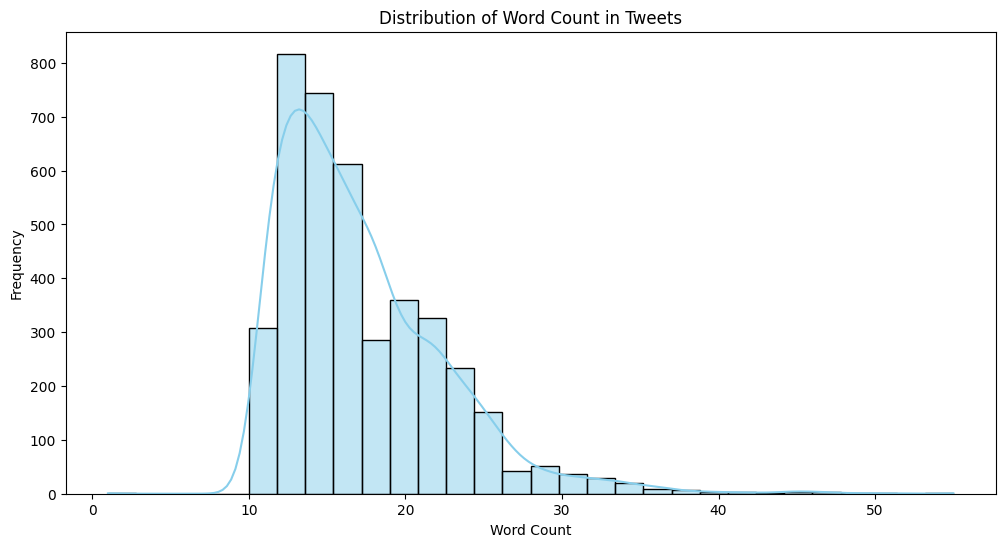

In [148]:

# Plot the distribution of the number of words in each tweet
df2['word_count'] = tweets_data['tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df2['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Word Count in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()



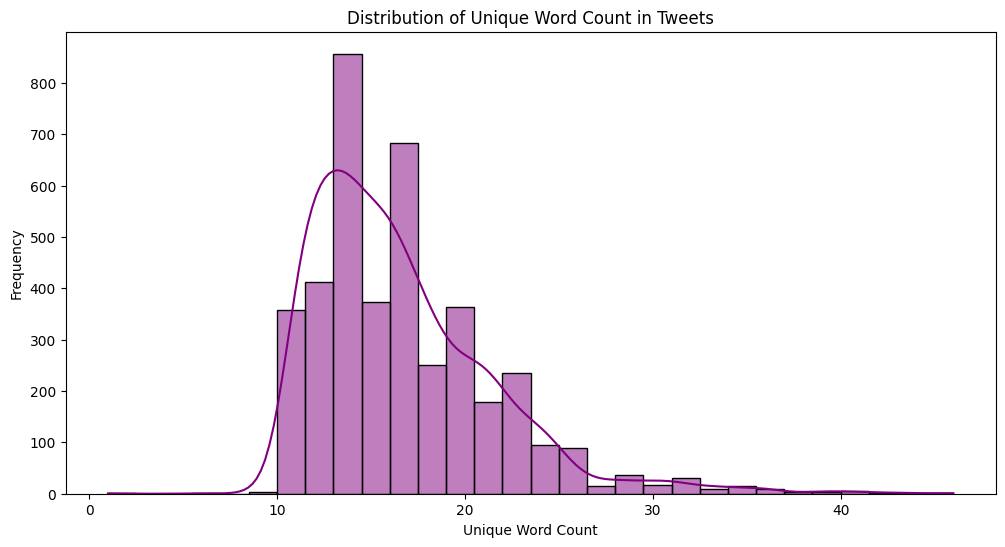

In [149]:

# Plot the number of unique words in each tweet
df2['unique_word_count'] = tweets_data['tweet'].apply(lambda x: len(set(x.split())))
plt.figure(figsize=(12, 6))
sns.histplot(df2['unique_word_count'], bins=30, kde=True, color='purple')
plt.title('Distribution of Unique Word Count in Tweets')
plt.xlabel('Unique Word Count')
plt.ylabel('Frequency')
plt.show()

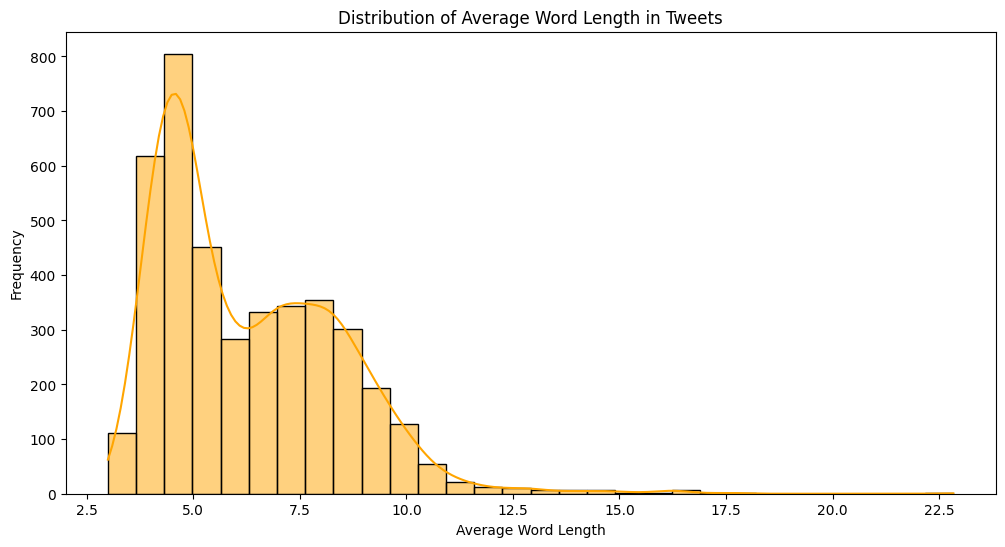

In [150]:

# Plot the average word length in each tweet
df2['avg_word_length'] = tweets_data['tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
plt.figure(figsize=(12, 6))
sns.histplot(df2['avg_word_length'], bins=30, kde=True, color='orange')
plt.title('Distribution of Average Word Length in Tweets')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.show()

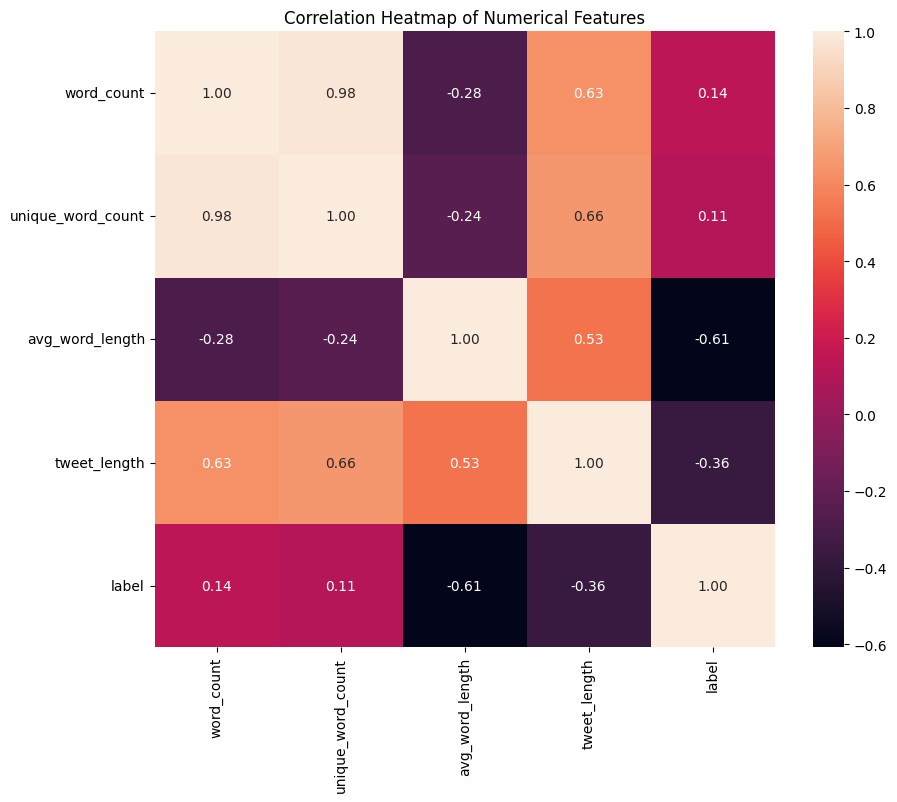

In [151]:


# Correlation heatmap between numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df2[['word_count', 'unique_word_count', 'avg_word_length', 'tweet_length', 'label']].corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Split the Data into Training and Testing :

In [152]:

def data_split(data, target_column, test_size=0.2, random_state=42):
  """
    Splits the provided dataset into training and testing sets.

    Args:
        data (pd.DataFrame): The dataset to be split, containing both features and the target column.
        target_column (str): The name of the column in the dataset that serves as the target variable.
                             This column should contain binary (0s and 1s) and categorical data.
        test_size (float, optional): The proportion of the dataset to include in the test split. It should be between 0.0 and 1.0.
                                     Default is 0.2.
        random_state (int, optional): A random state seed for reproducibility of the split. Default is 42.

    Returns:
        tuple: A tuple containing four elements:
            X_train (np.ndarray): The training set features.
            X_test (np.ndarray): The testing set features.
            y_train (np.ndarray): The training set target variable, reshaped as a two-dimensional array.
            y_test (np.ndarray): The testing set target variable, reshaped as a two-dimensional array.

    Notes:
        - The function assumes that the target variable is already encoded as binary and categorical.
        - The 'id' column is expected to be present in the data and is dropped from the features before splitting.
        - The function uses `train_test_split` from `sklearn.model_selection` for splitting data.

  """
  # Assuming target is already binary (0s and 1s) and categorical
  target = data[target_column]

  # Drop the original target column and 'id' column from the features
  features = data.drop(columns=[target_column, 'id'])

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)
 # Convert target variables to NumPy arrays and reshape them

  y_train =list( y_train)
  y_test = list(y_test)

  # Convert feature variables to NumPy arrays
  X_train = list(X_train.to_numpy().squeeze())
  X_test = list(X_test.to_numpy().squeeze())

  return X_train, X_test, y_train, y_test



train_x, test_x, train_y, test_y = data_split(tweets_data,'label')

<a name='1'></a>
## 1 - Process the Data

For any machine learning project, once we've gathered the data, the first step is to process it to make useful inputs to your model.
- **Remove noise**: We will first want to remove noise from your data -- that is, remove words that don't tell you much about the content. These include all common words like 'I, you, are, is, etc...' that would not give us enough information on the sentiment.
- We'll also remove stock market tickers, retweet symbols, hyperlinks, and hashtags because they can not tell you a lot of information on the sentiment.
- We also want to remove all the punctuation from a tweet. The reason for doing this is because we want to treat words with or without the punctuation as the same word, instead of treating "happy", "happy?", "happy!", "happy," and "happy." as different words.
- Finally We want to use stemming to only keep track of one variation of each word. In other words, we'll treat "motivation", "motivated", and "motivate" similarly by grouping them within the same stem of "motiv-".

The function `process_tweet` defined below does the pervious explained instructions.

In [153]:


def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation

            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


# Example tweet
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://website.com.np"

# print cleaned tweet
print(process_tweet(custom_tweet))

['hello', 'great', 'day', ':)', 'good', 'morn']


<a name='1-1'></a>
### 1.1 - Implementing of Helper Functions to count tweets

To train the naive bayes model, we will need to compute a dictionary where the keys are a tuple (word, label) and the values are the corresponding frequency.  Note that the labels we'll use here are 1 for positive and 0 for negative.

we will also implement a `lookup` helper function that takes in the `freqs` dictionary, a word, and a label (1 or 0) and returns the number of times that word and label tuple appears in the collection of tweets.

For example: given a list of tweets `["i am rather excited", "you are rather happy"]` and the label 1, the function will return a dictionary that contains the following key-value pairs:

{
    ("rather", 1): 2,
    ("happi", 1) : 1,
    ("excit", 1) : 1
}

**Note:**

- Notice how for each word in the given string, the same label 1 is assigned to each word.
- Notice how the words "i" and "am" are not saved, since it was removed by process_tweet because it is a stopword.
- Notice how the word "rather" appears twice in the list of tweets, and so its count value is 2.


In [154]:


def count_tweets(result, tweets, ys):
    '''
    Input:
        result: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''

    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            # define the key, which is the word and label tuple
            pair = (word,y)

            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1

    return result

In [155]:
def lookup(freqs, word, label):
    '''
    Input:
        freqs: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Output:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [156]:
# Testing the function with example

result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}


## 2 - Train The Model using Naive Bayes

Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time.

#### So how do we train a Naive Bayes classifier?
- The first part of training a naive bayes classifier is to identify the number of classes that we have.
- we will create a probability for each class.
$P(D_{pos})$ is the probability that the document is positive.
$P(D_{neg})$ is the probability that the document is negative.
Use the formulas as follows and store the values in a dictionary:

$$P(D_{pos}) = \frac{D_{pos}}{D}\tag{1}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}\tag{2}$$

Where $D$ is the total number of documents, or tweets in this case, $D_{pos}$ is the total number of positive tweets and $D_{neg}$ is the total number of negative tweets.

#### Prior and Logprior

The prior probability represents the underlying probability in the target population that a tweet is positive versus negative.  In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".

The prior is the ratio of the probabilities $\frac{P(D_{pos})}{P(D_{neg})}$.
We can take the log of the prior to rescale it, and we'll call this the logprior

$$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$$.

Note that $log(\frac{A}{B})$ is the same as $log(A) - log(B)$.  So the logprior can also be calculated as the difference between two logs:


$$\text{logprior} = \log (P(D_{pos})) - \log (P(D_{neg})) = \log (D_{pos}) - \log (D_{neg})\tag{3}$$

#### Positive and Negative Probability of a Word
To compute the positive probability and the negative probability for a specific word in the vocabulary, we'll use the following inputs:

- $freq_{pos}$ and $freq_{neg}$ are the frequencies of that specific word in the positive or negative class. In other words, the positive frequency of a word is the number of times the word is counted with the label of 1.
- $N_{pos}$ and $N_{neg}$ are the total number of positive and negative words for all documents (for all tweets), respectively.
- $V$ is the number of unique words in the entire set of documents, for all classes, whether positive or negative.

We'll use these to compute the positive and negative probability for a specific word using this formula:

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

Notice that we add the "+1" in the numerator for additive smoothing.  This [ article](https://en.wikipedia.org/wiki/Additive_smoothing) explains more about additive smoothing.

#### Log likelihood
To compute the loglikelihood of that very same word, we can implement the following equations for Log-Likelihood :

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)\tag{6}$$

In [157]:
# Build the freqs dictionary for later uses
freqs = count_tweets({}, train_x, train_y)

In [158]:
# First 8 elements of freqs dictionary
dict(itertools.islice(freqs.items(), 8))

{('tri', 1): 54,
 ('speak', 1): 5,
 ('someon', 1): 19,
 ('appl', 1): 1018,
 ('sort', 1): 6,
 ('new', 1): 153,
 ('batteri', 1): 46,
 ('mac', 1): 45}

<a name='ex-2'></a>
### 2 - train_naive_bayes
Given a freqs dictionary, `train_x` (a list of tweets) and a `train_y` (a list of labels for each tweet), we'll implement a naive bayes classifier.

##### Calculate $V$
- We can then compute the number of unique words that appear in the `freqs` dictionary to get the $V$ (we can use the `set` function).

##### Calculate $freq_{pos}$ and $freq_{neg}$
- Using the `freqs` dictionary, we can compute the positive and negative frequency of each word $freq_{pos}$ and $freq_{neg}$.

##### Calculate $N_{pos}$, and $N_{neg}$
- Using `freqs` dictionary, we can also compute the total number of positive words and total number of negative words $N_{pos}$ and $N_{neg}$.

##### Calculate $D$, $D_{pos}$, $D_{neg}$
- Using the `train_y` input list of labels, we'll calculate the number of documents (tweets) $D$, as well as the number of positive documents (tweets) $D_{pos}$ and number of negative documents (tweets) $D_{neg}$.
- Calculate the probability that a document (tweet) is positive $P(D_{pos})$, and the probability that a document (tweet) is negative $P(D_{neg})$

##### Calculate the logprior
- the logprior is $log(D_{pos}) - log(D_{neg})$

##### Calculate log likelihood
- Finally, we can iterate over each word in the vocabulary, use your `lookup` function to get the positive frequencies, $freq_{pos}$, and the negative frequencies, $freq_{neg}$, for that specific word.
- Compute the positive probability of each word $P(W_{pos})$, negative probability of each word $P(W_{neg})$ using equations 4 & 5.

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

**Note:** We'll use a dictionary to store the log likelihoods for each word.  The key is the word, the value is the log likelihood of that word).

- we can then compute the loglikelihood: $log \left( \frac{P(W_{pos})}{P(W_{neg})} \right)$.

In [159]:


def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels corresponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    ### START CODE HERE ###

    # calculate V, the number of unique words in the vocabulary
    vocab = {key[0] for key in freqs.keys()}
    V = len(vocab)

    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D =len(train_y)

    # Calculate D_pos, the number of positive documents
    D_pos = sum(train_y)

    # Calculate D_neg, the number of negative documents
    D_neg = D-D_pos

    # Calculate logprior
    logprior = np.log(D_pos)- np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs, word,1)
        freq_neg = lookup(freqs, word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)



    return logprior, loglikelihood

In [160]:

logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.008022258389143389
7754


<a name='3'></a>
## 3 - Test The Naive Bayes Classifier :

Now that we have the `logprior` and `loglikelihood`, we can test the naive bayes function by making predicting on some tweets!

<a name='ex-3'></a>
###  naive_bayes_predict Function :
Implementation of  `naive_bayes_predict`:

* The function takes in the `tweet`, `logprior`, `loglikelihood`.
* It returns the probability that the tweet belongs to the positive or negative class.
* For each tweet, sum up loglikelihoods of each word in the tweet.
* Also add the logprior to this sum to get the predicted sentiment of that tweet.

$$ p = logprior + \sum_i^N (loglikelihood_i)$$



In [161]:


def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to the value of LogPrior
    p = logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]



    return p



#### test_naive_bayes :
**Instructions**:
* we'll Implement `test_naive_bayes` to check the accuracy, precision, recall and F1 of the predictions.
* The function takes in the `test_x`, `test_y`, log_prior, and loglikelihood
* It returns the accuracy of the model as well as the other metrics


In [162]:


def test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict):
    """
    Test the logistic regression model and return its accuracy and classification report.

    Parameters:
    test_x (list): A list of tweets.
    test_y (np.ndarray): A numpy array with the corresponding labels for the list of tweets.
    freqs (dict): A dictionary with the frequency of each pair (or tuple).
    theta (np.ndarray): Weight vector of dimension (3, 1).
    predict_tweet (function): A function to predict the sentiment of a tweet.

    Returns:
    float, dict: The accuracy and a dictionary containing the classification report.
    """


    accuracy = 0  # return this properly


    y_hats = []

    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(abs(np.array(y_hats)-np.array(test_y)))

    # Accuracy is 1 minus the error
    accuracy = 1-error

    # Generate classification report
    report = classification_report(np.array(test_y), np.array(y_hats), output_dict=True)

    return accuracy, report


def print_classification_report(report,accuracy):
    """
    Print the classification report.

    Parameters:
    report (dict): A dictionary containing the classification report.
    """
    print("Classification Report:")
    print("Accuracy:", round(accuracy,2)*100,"%")

    for key, value in report.items():
        if isinstance(value, dict):
            print(f"\nClass {key}:")
            for score, score_value in value.items():
                print(f"{score.capitalize()}: {score_value:.2f}")
        else:
            print(f"{key.capitalize()}: {value:.2f}")




In [163]:
accuracy, report = test_naive_bayes(test_x, test_y, logprior, loglikelihood)

print_classification_report(report,accuracy)

Classification Report:
Accuracy: 88.0 %

Class 0:
Precision: 0.93
Recall: 0.82
F1-score: 0.87
Support: 412.00

Class 1:
Precision: 0.83
Recall: 0.93
F1-score: 0.88
Support: 399.00
Accuracy: 0.88

Class macro avg:
Precision: 0.88
Recall: 0.88
F1-score: 0.88
Support: 811.00

Class weighted avg:
Precision: 0.88
Recall: 0.88
F1-score: 0.88
Support: 811.00


In [164]:

# Test The function on customised tweets

for tweet in ['I am not happy', 'my computer is good ', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    # print( '%s -> %f' % (tweet, naive_bayes_predict(tweet, logprior, loglikelihood)))
    p_category='negative'
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
    if p>0 : p_category='positive'
    print(f'{tweet} -> {p:.2f} ({p_category})')


I am not happy -> -2.80 (negative)
my computer is good  -> 1.02 (positive)
this movie should have been great. -> -1.10 (negative)
great -> 0.15 (positive)
great great -> 0.29 (positive)
great great great -> 0.43 (positive)
great great great great -> 0.57 (positive)



## 4 - Filter words by Ratio of Positive to Negative Counts

- Some words have more positive counts than others, and can be considered "more positive".  Likewise, some words can be considered more negative than others.
- One way for us to define the level of positiveness or negativeness, without calculating the log likelihood, is to compare the positive to negative frequency of the word.
    - Note that we can also use the log likelihood calculations to compare relative positivity or negativity of words.
- We can calculate the ratio of positive to negative frequencies of a word.
- Once we're able to calculate these ratios, we can also filter a subset of words that have a minimum ratio of positivity / negativity or higher.
- Similarly, we can also filter a subset of words that have a maximum ratio of positivity / negativity or lower (words that are at least as negative, or even more negative than a given threshold).



### Implementation of `get_ratio` :

- Given the freqs dictionary of words and a particular word, we will use `lookup(freqs,word,1)` to get the positive count of the word.
- Similarly, we will also  use the `lookup` function to get the negative count of that word.
-Then calculate the ratio of positive divided by negative counts

$$ ratio = \frac{\text{pos_words} + 1}{\text{neg_words} + 1} $$

Where pos_words and neg_words correspond to the frequency of the words in their respective classes.
<table>
    <tr>
        <td>
            <b>Words</b>
        </td>
        <td>
        Positive word count
        </td>
         <td>
        Negative Word Count
        </td>
  </tr>
    <tr>
        <td>
        glad
        </td>
         <td>
        41
        </td>
    <td>
        2
        </td>
  </tr>
    <tr>
        <td>
        arriv
        </td>
         <td>
        57
        </td>
    <td>
        4
        </td>
  </tr>
    <tr>
        <td>
        :(
        </td>
         <td>
        1
        </td>
    <td>
        3663
        </td>
  </tr>
    <tr>
        <td>
        :-(
        </td>
         <td>
        0
        </td>
    <td>
        378
        </td>
  </tr>
</table>

In [165]:


def get_ratio(freqs, word):
    '''
    Input:
        freqs: dictionary containing the words

    Output: a dictionary with keys 'positive', 'negative', and 'ratio'.
        Example: {'positive': 10, 'negative': 20, 'ratio': 0.5}
    '''
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}

    # use lookup() to find positive counts for the word (denoted by the integer 1)
    pos_neg_ratio['positive'] = lookup(freqs,word,1)

    # use lookup() to find negative counts for the word (denoted by integer 0)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)

    # calculate the ratio of positive to negative counts for the word
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive']+1) / (pos_neg_ratio['negative']+1)

    return pos_neg_ratio


In [166]:
get_ratio(freqs, 'happi')

{'positive': 4, 'negative': 94, 'ratio': 0.05263157894736842}


### 6 - get_words_by_threshold

Implementation of  `get_words_by_threshold(freqs,label,threshold)`

* If we set the label to 1, then we'll look for all words whose threshold of positive/negative is at least as high as that threshold, or higher.
* If we set the label to 0, then we'll look for all words whose threshold of positive/negative is at most as low as the given threshold, or lower.
* We will Use the `get_ratio` function to get a dictionary containing the positive count, negative count, and the ratio of positive to negative counts.
* We will Append the `get_ratio` dictionary inside another dictinoary, where the key is the word, and the value is the dictionary `pos_neg_ratio` that is returned by the `get_ratio` function.
An example key-value pair would have this structure:

```
{'happi':
    {'positive': 10, 'negative': 20, 'ratio': 0.524}
}
```

In [167]:


def get_words_by_threshold(freqs, label, threshold, get_ratio=get_ratio):
    '''
    Input:
        freqs: dictionary of words
        label: 1 for positive, 0 for negative
        threshold: ratio that will be used as the cutoff for including a word in the returned dictionary
    Output:
        word_list: dictionary containing the word and information on its positive count, negative count, and ratio of positive to negative counts.
        example of a key value pair:
        {'happi':
            {'positive': 10, 'negative': 20, 'ratio': 0.5}
        }
    '''
    word_list = {}


    for key in freqs.keys():
        word, _ = key

        # get the positive/negative ratio for a word
        pos_neg_ratio = get_ratio(freqs,word)

        # if the label is 1 and the ratio is greater than or equal to the threshold...
        if label == 1 and pos_neg_ratio['ratio'] >= threshold:

            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio

        # If the label is 0 and the pos_neg_ratio is less than or equal to the threshold...
        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:

            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio

        # otherwise, do not include this word in the list (do nothing)


    return word_list


In [168]:
# Test the function: find negative words at or below a threshold
get_words_by_threshold(freqs, label=0, threshold=0.05)

{'instagood': {'positive': 0, 'negative': 64, 'ratio': 0.015384615384615385},
 'iphonesia': {'positive': 0, 'negative': 36, 'ratio': 0.02702702702702703},
 'photooftheday': {'positive': 0,
  'negative': 47,
  'ratio': 0.020833333333333332},
 'instamood': {'positive': 0, 'negative': 25, 'ratio': 0.038461538461538464},
 'iger': {'positive': 0, 'negative': 45, 'ratio': 0.021739130434782608},
 'cute': {'positive': 0, 'negative': 100, 'ratio': 0.009900990099009901},
 'instadaili': {'positive': 0, 'negative': 20, 'ratio': 0.047619047619047616},
 'iphoneonli': {'positive': 0, 'negative': 34, 'ratio': 0.02857142857142857},
 'follow': {'positive': 3, 'negative': 271, 'ratio': 0.014705882352941176},
 'gift': {'positive': 0, 'negative': 41, 'ratio': 0.023809523809523808},
 'photographi': {'positive': 2, 'negative': 87, 'ratio': 0.03409090909090909},
 'fashion': {'positive': 2, 'negative': 66, 'ratio': 0.04477611940298507},
 'picoftheday': {'positive': 0, 'negative': 25, 'ratio': 0.038461538461538

In [169]:
# Test the function; find positive words at or above a threshold
get_words_by_threshold(freqs, label=1, threshold=10)

{'spent': {'positive': 12, 'negative': 0, 'ratio': 13.0},
 'suck': {'positive': 82, 'negative': 5, 'ratio': 13.833333333333334},
 'left': {'positive': 9, 'negative': 0, 'ratio': 10.0},
 'fuck': {'positive': 209, 'negative': 5, 'ratio': 35.0},
 'stop': {'positive': 30, 'negative': 2, 'ratio': 10.333333333333334},
 'stupid': {'positive': 47, 'negative': 2, 'ratio': 16.0},
 'yet': {'positive': 19, 'negative': 1, 'ratio': 10.0},
 'either': {'positive': 9, 'negative': 0, 'ratio': 10.0},
 'hate': {'positive': 111, 'negative': 8, 'ratio': 12.444444444444445},
 'cost': {'positive': 9, 'negative': 0, 'ratio': 10.0},
 'piss': {'positive': 30, 'negative': 1, 'ratio': 15.5},
 'text': {'positive': 39, 'negative': 2, 'ratio': 13.333333333333334},
 'sync': {'positive': 26, 'negative': 1, 'ratio': 13.5},
 'updat': {'positive': 156, 'negative': 10, 'ratio': 14.272727272727273},
 'fix': {'positive': 53, 'negative': 3, 'ratio': 13.5},
 'id': {'positive': 10, 'negative': 0, 'ratio': 11.0},
 'restor': {'po

Notice the difference between the positive and negative ratios. Emojis like :( and words like 'me' tend to have a negative connotation. Other words like glad, community, arrives, tend to be found in the positive tweets.

<a name='5'></a>
## 5 - Error Analysis

In this part we will see some tweets that the model missclassified. Why do we think the missclassifications happened? Were there any assumptions made by the naive bayes model?

In [170]:
# Some error analysis done
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
0	1.00	b'see mani featur know iphon ... iphon yourtechcompani pic.twitter.com/wm6ixddugl'
0	1.00	b"feel broken phone' screen replac ... iphon happi pic.twitter.com/ygsuke2c"
0	1.00	b'less 24 hour left iphon countdown cantwait byeby appl'
1	0.00	b'welcom 80 appl soni everybodi cook soup lightpeak rest peac lightpeak standard soni appl'
0	1.00	b'... woke babi still right next iphon know would without reliev .. <- lmao'
1	0.00	b'dream bought new iphon nightmar neveragain'
0	1.00	b'wait ipad 4 arriv appl pic.twitter.com/cvibdzjrxw'
0	1.00	b'new laptop soni vaio laptop lap top lap bottom comput litup keyboard screen'
0	1.00	b"steve job god world would'v addict technolog anyway tri give better version steve"
0	1.00	b"that' get samsung s5 bend throw wall still work blessedinde"
0	1.00	b'havent phone 5 hour dont tink last till 12 tomorrow'
0	1.00	b'tear ps3 apart find problem fix put back togeth less 20 minut playstat soni ps3'
0	1.00	b'top io news week iphon sale ipad sa

<a name='6'></a>
## 6 - Predict with your own Tweet

In this part you can predict the sentiment of your own tweet.

In [171]:
# Test with your own tweet - feel free to modify `my_tweet`
my_tweet = 'apple have great phones  !  '


p = naive_bayes_predict(my_tweet, logprior, loglikelihood)

sentiment='negative'
if p>=0 : sentiment = 'positive'

print(sentiment)

positive
